In [1]:
!pip install grad-cam
!pip install ttach
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.8 MB 24.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.9-py3-none-any.whl size=25984 sha256=9f206c6045af5d4d9b904cb1584b5cf8b4ea64691e076bd462e665b5b8fce6d6
  Stored in directory: /root/.cache/pip/wheels/65/e8/6e/6eedfbe3f0007dfd8116e6820b69691c4103d89ad2ae8c69ff
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
from functools import partial
from typing import Any, Callable, Dict, List, Optional, Sequence
import math

from colorama import Fore, Back, Style
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
from torch import nn, Tensor
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models
from torch.hub import load_state_dict_from_url
from torchvision.models.mobilenetv2 import _make_divisible, ConvBNActivation

In [3]:
# hyper parameters

batch_size = 64
num_workers = 2
input_size = 112

epochs = 5
lr = 0.001
embedding_size = 512

save_model = True
validation = True

##Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# dataset_dir_path = '/content/drive/MyDrive/datasets/Flowers/Train'
dataset_dir_path = '/content/drive/MyDrive/ComputerVisionDeepLearning/retineurali/Images_for_MOBILENET/test'

transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.CenterCrop(input_size),
                                transforms.RandomHorizontalFlip(),
                                # transforms.RandomRotation(20),
                                transforms.Resize((input_size,input_size)),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                #                      std=[0.229, 0.224, 0.225])
                                ])

train_dataset = torchvision.datasets.ImageFolder(root=dataset_dir_path, transform=transform)

In [6]:
if validation:
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_set, num_workers=num_workers, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_set, num_workers=num_workers, shuffle=True, batch_size=batch_size)
    print(train_size, val_size)

else:
    train_dataloader = DataLoader(train_dataset, num_workers=num_workers, shuffle=True, batch_size=batch_size)
    train_size = int(len(train_dataset))
    print(train_size)

num_classes = len(train_dataset.classes)

188 48


tensor(0)
torch.Size([3, 112, 112])


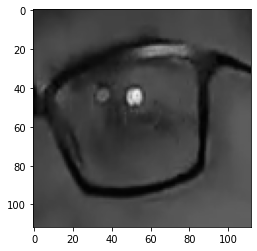

In [7]:
data, target = iter(train_dataloader).next()

print(target[0])
print(data[0].shape)
image = data[0].permute(1, 2, 0)
plt.imshow(image)

##Model

In [8]:
class sa_layer(nn.Module):
    def __init__(self, channel, groups=4):
        super(sa_layer, self).__init__()
        self.groups = groups
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.cweight = Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.cbias = Parameter(torch.ones(1, channel // (2 * groups), 1, 1))
        self.sweight = Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.sbias = Parameter(torch.ones(1, channel // (2 * groups), 1, 1))

        self.sigmoid = nn.Sigmoid()
        self.gn = nn.GroupNorm(channel // (2 * groups), channel // (2 * groups))

    @staticmethod
    def channel_shuffle(x, groups):
        b, c, h, w = x.shape

        x = x.reshape(b, groups, -1, h, w)
        x = x.permute(0, 2, 1, 3, 4)

        # flatten
        x = x.reshape(b, -1, h, w)
        return x

    def forward(self, x):
        b, c, h, w = x.shape

        x = x.reshape(b * self.groups, -1, h, w)
        x_0, x_1 = x.chunk(2, dim=1)

        # channel attention
        xn = self.avg_pool(x_0)
        xn = self.cweight * xn + self.cbias
        xn = x_0 * self.sigmoid(xn)

        # spatial attention
        xs = self.gn(x_1)
        xs = self.sweight * xs + self.sbias
        xs = x_1 * self.sigmoid(xs)

        # concatenate along channel axis
        out = torch.cat([xn, xs], dim=1)
        out = out.reshape(b, -1, h, w)

        out = self.channel_shuffle(out, 2)
        return out


class InvertedResidualConfig:
    def __init__(self, input_channels: int, kernel: int, expanded_channels: int, out_channels: int, use_se: bool,
                 activation: str, stride: int, dilation: int, width_mult: float):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):
    def __init__(self, cnf: InvertedResidualConfig, norm_layer: Callable[..., nn.Module]):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError('illegal stride value')

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # expand
        if cnf.expanded_channels != cnf.input_channels:
            layers.append(ConvBNActivation(cnf.input_channels, cnf.expanded_channels, kernel_size=1,
                                           norm_layer=norm_layer, activation_layer=activation_layer))

        # depthwise
        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(ConvBNActivation(cnf.expanded_channels, cnf.expanded_channels, kernel_size=cnf.kernel,
                                       stride=stride, dilation=cnf.dilation, groups=cnf.expanded_channels,
                                       norm_layer=norm_layer, activation_layer=activation_layer))
        if cnf.use_se:
            layers.append(sa_layer(cnf.expanded_channels))

        # project
        layers.append(ConvBNActivation(cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer,
                                       activation_layer=nn.Identity))

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


class MobileNetV3(nn.Module):
    def __init__(self,
                 inverted_residual_setting: List[InvertedResidualConfig],
                 last_channel: int,
                 num_classes: int = 1000,
                 embedding_size: int = 512,
                 block: Optional[Callable[..., nn.Module]] = None,
                 norm_layer: Optional[Callable[..., nn.Module]] = None):
        """
        MobileNet V3 main class
        Args:
            inverted_residual_setting (List[InvertedResidualConfig]): Network structure
            last_channel (int): The number of channels on the penultimate layer
            num_classes (int): Number of classes
            block (Optional[Callable[..., nn.Module]]): Module specifying inverted residual building block for mobilenet
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
        """
        super().__init__()

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (isinstance(inverted_residual_setting, Sequence) and
                  all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(ConvBNActivation(3, firstconv_output_channels, kernel_size=3, stride=2, norm_layer=norm_layer,
                                       activation_layer=nn.Hardswish))

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(ConvBNActivation(lastconv_input_channels, lastconv_output_channels, kernel_size=1,
                                       norm_layer=norm_layer, activation_layer=nn.Hardswish))

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)


    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def _mobilenet_v3_conf(arch: str, params: Dict[str, Any]):
    # non-public config parameters
    reduce_divider = 2 if params.pop('_reduced_tail', False) else 1
    dilation = 2 if params.pop('_dilated', False) else 1
    width_mult = params.pop('_width_mult', 1.0)

    bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    if arch == "mobilenet_v3_large":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1280 // reduce_divider)  # C5
    elif arch == "mobilenet_v3_small":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, True, "RE", 2, 1),  # C1
            bneck_conf(16, 3, 72, 24, False, "RE", 2, 1),  # C2
            bneck_conf(24, 3, 88, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 96, 40, True, "HS", 2, 1),  # C3
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 120, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 144, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 288, 96 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1024 // reduce_divider)  # C5
    else:
        raise ValueError("Unsupported model type {}".format(arch))

    return inverted_residual_setting, last_channel


def _mobilenet_v3_model(
    arch: str,
    inverted_residual_setting: List[InvertedResidualConfig],
    last_channel: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any): #**kwargs
    model = MobileNetV3(inverted_residual_setting, last_channel, **kwargs) #**kwargs
    return model


def mobilenet_v3_large(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3: #**kwargs
    arch = "mobilenet_v3_large"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs)
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs) #**kwargs


def mobilenet_v3_small(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3: #**kwargs
    arch = "mobilenet_v3_small"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs) 
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs) #**kwargs

In [9]:
device = torch.device('cuda')
model = mobilenet_v3_large(embedding_size=embedding_size, num_classes=num_classes).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/mobilenetv2.py:28: FutureWarning: The ConvBNReLU/ConvBNActivation classes are deprecated since 0.12 and will be removed in 0.14. Use torchvision.ops.misc.ConvNormActivation instead.
  FutureWarning,


##Train

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
def calc_acc(preds: torch.Tensor, labels: torch.Tensor):
    _, pred_max = torch.max(preds, 1)
    acc = torch.sum(pred_max == labels.data, dtype=torch.float64) / len(preds)
    return acc

In [12]:
tic = time.time()

for epoch in range(1, epochs + 1):
    model.train(True)
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in tqdm(train_dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        preds = model(images)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        optimizer.step()

        train_loss += loss
        train_acc += calc_acc(preds, labels)

    total_loss = train_loss / len(train_dataloader)
    total_acc = train_acc / len(train_dataloader)
    print(Fore.GREEN, f"Epoch: {epoch} [Train Loss: {total_loss}] [Train Accuracy: {total_acc}] [lr: {optimizer.param_groups[0]['lr']}]", Fore.RESET)

    if validation:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for images, labels in tqdm(val_dataloader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                
                preds = model(images)
                loss = loss_fn(preds, labels)
                val_loss += loss
                val_acc += calc_acc(preds, labels)

            total_loss = val_loss / len(val_dataloader)
            # total_loss = 0
            total_acc = val_acc / len(val_dataloader)
            print(Fore.BLUE, f"[Validation Loss: {total_loss}] [Validation Accuracy: {total_acc}]", Fore.RESET)

    scheduler.step()

tac = time.time()
print("Time Taken : ", tac - tic)

torch.save(model.state_dict(), "weights.pth")

Training: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


 Epoch: 1 [Train Loss: 0.7504892349243164] [Train Accuracy: 0.5684027777777777] [lr: 0.001] 


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


 [Validation Loss: 0.687009334564209] [Validation Accuracy: 0.7083333333333333] 


Training: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


 Epoch: 2 [Train Loss: 0.7110258936882019] [Train Accuracy: 0.6739583333333333] [lr: 0.001] 


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


 [Validation Loss: 0.6825957298278809] [Validation Accuracy: 0.7083333333333333] 


Training: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


 Epoch: 3 [Train Loss: 0.6403369903564453] [Train Accuracy: 0.664236111111111] [lr: 0.001] 


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


 [Validation Loss: 0.679615318775177] [Validation Accuracy: 0.7083333333333333] 


Training: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


 Epoch: 4 [Train Loss: 0.6405803561210632] [Train Accuracy: 0.6371527777777778] [lr: 0.001] 


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


 [Validation Loss: 0.6742954850196838] [Validation Accuracy: 0.7083333333333333] 


Training: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


 Epoch: 5 [Train Loss: 0.5446305274963379] [Train Accuracy: 0.7336805555555556] [lr: 0.001] 


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

 [Validation Loss: 0.6601148843765259] [Validation Accuracy: 0.7083333333333333] 
Time Taken :  9.903676986694336


##Test

In [13]:
torch.cuda.empty_cache()
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): _DeprecatedConvBNAct(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): _DeprecatedConvBNAct(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): _DeprecatedConvBNAct(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): _DeprecatedConvBNAct(
          (0): Conv2d(16, 64, kernel_size

In [14]:
model.load_state_dict(torch.load("weights.pth", map_location=device), strict=False)

<All keys matched successfully>

In [15]:
dataset_dir_path = '/content/drive/MyDrive/ComputerVisionDeepLearning/retineurali/Images_for_MOBILENET/random'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((input_size,input_size))
                                ])

test_dataset = torchvision.datasets.ImageFolder(root=dataset_dir_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

num_classes = len(test_dataset.classes)

In [16]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, num_workers=num_workers, shuffle=False, batch_size=batch_size)
num_classes = len(test_dataset.classes)
print(num_classes)

2


tensor(0)
torch.Size([3, 112, 112])


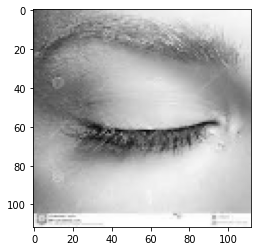

In [17]:
data, target = iter(test_dataloader).next()

print(target[0])
print(data[0].shape)
image = data[0].permute(1, 2, 0)
plt.imshow(image)

In [18]:
test_acc = 0.0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        
        preds = model(images)
        test_acc += calc_acc(preds, labels)

acc = test_acc / len(test_dataloader)
print(Fore.BLUE, f"[Test Accuracy: {acc}]", Fore.RESET)

Testing: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

 [Test Accuracy: 0.5] 


In [19]:
class ConfusionMatrix(torch.nn.Module):
    """Module for calculating confusion matrix w/ PyTorch"""
    def __init__(self):
        super().__init__()

    def calculate_single_channel(self, y_true, y_pred):
        y_true_idx, y_pred_idx = torch.meshgrid(
            y_true.unique(sorted=True), 
            y_pred.unique(sorted=True), 
            indexing="ij"
        )
        conf_mat = torch.zeros_like(y_true_idx)
        for i in range(y_true_idx.shape[0]):
            for j in range(y_true_idx.shape[1]):
                conf_mat[i, j] = torch.sum(
                    torch.logical_and(y_true == y_true_idx[i, j], y_pred == y_pred_idx[i, j])
                )
        return conf_mat

    def forward(self, y_true, y_pred, stack: bool = True):
        """Caclulate the confusion matrix

        Args:
            y_true: true value tensor
            y_pred: predicted value tensor
            stack: bool for if module will try to stack the channel-wise results
                or return list
        Return:
            channel-wise confusion matrix results
        """
        if y_true.dim() > 2:
            if stack:
                return torch.stack([
                    self.calculate_single_channel(t, p) for t, p in zip(y_true, y_pred) 
                ])
            else:
                return [
                    self.calculate_single_channel(t, p) for t, p in zip(y_true, y_pred) 
                ]
        else:
            return self.calculate_single_channel(y_true, y_pred)